In [1]:
import sys
path = '/tf/notebooks/Capstone/backend/src'
sys.path.append(path)

import ktrain
from ktrain import text
from time_series_analysis.time_series import TimeSeries
import pandas as pd
import random
import spacy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.utils import to_categorical
import numpy as np
import math

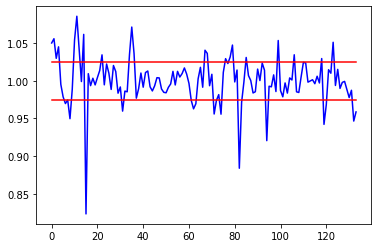

30500


In [2]:
input_csv_text = '../../data/airliner_completed.csv'
csv = pd.read_csv(input_csv_text)
texts = csv[['Text', 'Datum']].values

for text_id in range(len(texts)):
    date = texts[text_id][1]
    if len(date) == 10:
        date = date[3:]
    if len(date) == 9:
        date = date[2:]
    if date == 'Datum':
        date = '00.0000'
    texts[text_id][1] = date

time_series = TimeSeries()
time_series.plot_results(time_series.get_residuums(), spread=0.025)
labels = time_series.get_residuums_dates(spread=0.025, four_cat=False)

def merge_data(texts, labels, sliding_window=1):
    final_texts = []
    final_labels = []
    for text_id in range(len(texts)):
        for label_id in range(len(labels) - sliding_window):
            if texts[text_id][1] == labels[label_id + sliding_window][1][3:]:
                final_texts.append(texts[text_id][0])
                final_labels.append(labels[label_id + sliding_window][0])
    return final_texts, final_labels

texts, labels = merge_data(texts, labels, sliding_window=4)
labels = to_categorical(labels)
print(len(texts))

In [24]:
four_classes = False
epochs = 5
learning_rate = 5e-5
batch_size = 4
max_length = 512
max_words = 25000

In [4]:
nlp = spacy.load('de_core_news_sm')
stemmer = PorterStemmer()
stoplist = stopwords.words('german')

In [5]:
if four_classes:
    class_names = ['least', 'less', 'more', 'most']
else:
    class_names = ['less', 'equal', 'more']

In [6]:
def lemmatize_remove_stop(texts, stoplist):
    lemmatized_texts = []
    for document in list(nlp.pipe(texts, disable=['tagger', 'parser', 'ner'])):
        current_text = []
        for token in document:
            if token.lemma_ not in stoplist:
                current_text.append(token.lemma_)

        lemmatized_texts.append(' '.join(current_text))
    return lemmatized_texts

texts = lemmatize_remove_stop(texts, stoplist)

In [7]:
data = []
if four_classes:
    for t, label in zip(texts, labels):
        data.append([t, label[0], label[1], label[2], label[3]])
else:
    for t, label in zip(texts, labels):
        data.append([t, label[0], label[1], label[2]])

In [8]:
def split_test_data(data, split=0.1, random_seed=42):
    np.random.seed(random_seed)
    np.random.shuffle(data)
    split_item = math.floor(split * len(data))
    print('split at: ', split_item)
    x_test, y_test = data[:split_item, 0], data[:split_item, 1:]
    x_train, y_train = data[split_item:, 0], data[split_item:, 1:]
    return x_train, y_train, x_test, y_test

In [9]:
x_train, y_train, x_val, y_val = split_test_data(np.array(data), split=0.15, random_seed=4242)
print(len(x_train), len(y_train), len(x_val), len(y_val))
y_train = [[int(float(e)) for e in l] for l in y_train]
y_val = [[int(float(e)) for e in l] for l in y_val]

split at:  4575
25925 25925 4575 4575


In [10]:
from sklearn.utils import class_weight
def generate_balanced_weights(y_train):
    y_labels = [y.argmax() for y in np.array(y_train)]
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_labels), y_labels)
    weight_dict = {}
    for key in range(len(class_weights)):
        weight_dict[key] = class_weights[key]
    return weight_dict

class_weight_dict = generate_balanced_weights(y_train)
print(class_weight_dict)

{0: 2.574990067540723, 1: 0.4492911857474611, 2: 2.5912043978010995}


In [11]:
MODEL ='distilbert-base-multilingual-cased'
MODEL_bert = 'bert-base-german-cased'
transformer = text.Transformer(MODEL_bert, maxlen=max_length, class_names=class_names)
train_data = transformer.preprocess_train(x_train, y_train)
val_data = transformer.preprocess_test(x_val, y_val)

preprocessing train...
language: de
train sequence lengths:
	mean : 201
	95percentile : 525
	99percentile : 890


Is Multi-Label? False
preprocessing test...
language: de
test sequence lengths:
	mean : 201
	95percentile : 524
	99percentile : 827


In [12]:
model = transformer.get_classifier()

In [25]:
learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, batch_size=batch_size)

In [26]:
learner.fit_onecycle(5e-5, epochs=epochs, class_weight=class_weight_dict)



begin training using onecycle policy with max lr of 5e-05...
Train for 6482 steps, validate for 143 steps
Epoch 1/5
6482/6482 [==============================] - 2208s 341ms/step - loss: 1.1074 - accuracy: 0.3453 - val_loss: 1.1073 - val_accuracy: 0.1220
Epoch 2/5
6482/6482 [==============================] - 2221s 343ms/step - loss: 1.1139 - accuracy: 0.3126 - val_loss: 1.1045 - val_accuracy: 0.1220
Epoch 3/5
  82/6482 [..............................] - ETA: 35:14 - loss: 1.1158 - accuracy: 0.3333

KeyboardInterrupt: 

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=transformer)

In [ ]:
confusion = learner.evaluate()

In [ ]:
# print confusion matrix
import matplotlib.pyplot as plt
import seaborn as sn
labels = class_names
cm_df = pd.DataFrame(confusion, labels, labels)
sn.set(font_scale=1.1, font='Arial')
ax = sn.heatmap(cm_df, cmap="Blues", annot=True, annot_kws={"size": 11}, cbar=False, fmt='g')
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title("Confusion Matrix")
plt.show()

In [ ]:
confusion = learner.evaluate()